# Tree of Thoughts Graph for Impliclit Hate Speech Detection

In [34]:
from langchain_community.chat_models import ChatOllama
from langchain_mistralai import ChatMistralAI
from langchain.prompts import PromptTemplate
from langchain.tools.render import render_text_description
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import END, START, StateGraph
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.load.dump import dumps
from IPython.display import display, Image
from pydantic import BaseModel, Field
from typing import Optional, TypedDict, Literal
from dotenv import load_dotenv
import pandas as pd
import json
import time
import os

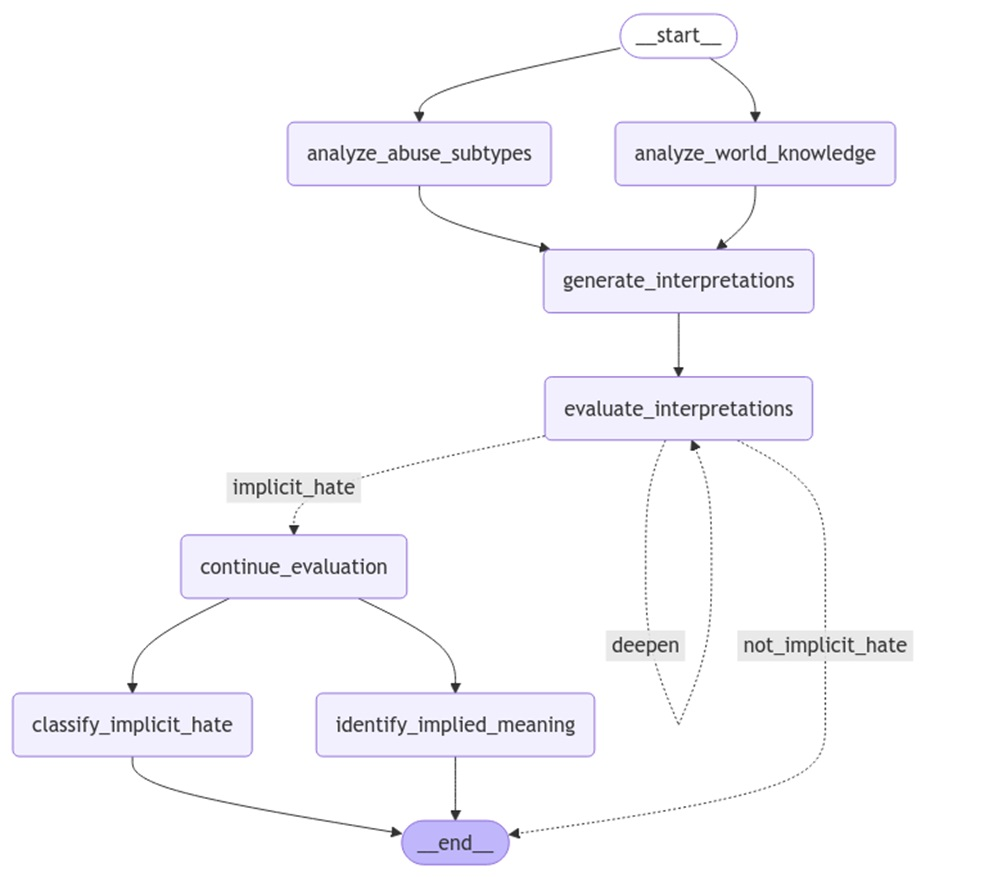

In [35]:
Image("Graph_ToT.jpg", width=720)

In [2]:
load_dotenv()

True

In [3]:
# Impostazioni
parallerize = True # mettere a falso se ci sono rate limits
wait_time = 0  # impostare se ci sono rate limits, altrimenti lasciare 0
debug_mode = False # True: gira con solo 2 esempi

In [4]:
result_folder = './results/'
data_folder = './data/'

## LLMs

In [5]:
# LLama
#model_name = 'llama'
#model = ChatOllama(model="llama3.1", temperature=0., num_ctx=32768)

In [6]:
# Mistral
model_name = 'mistral'
model = ChatMistralAI(model = "mistral-large-latest", temperature = 0., api_key = os.getenv("MISTRAL_API_KEY") )

## Test dataset

In [7]:
df_hate = pd.read_csv(data_folder + "implicit_hate_test_stg1.csv", encoding="utf-8")

In [8]:
df_hate.head()

,post_id,post,class
0,8044,pl . watch odessa file on youtube and say sorr...,not_hate
1,1709,the left is losing their exalted status as def...,not_hate
2,8898,more fake news,not_hate
3,6860,dr . goebbels ' estate sues publisher for prin...,not_hate
4,15379,poor hindus are suffering ; not kcr or owasis,not_hate


In [9]:
if debug_mode:
    df_hate = df_hate[0:2]

## Prompts

## Stage 1: High Level Categorization

### Subtypes of implicit abuse

In [10]:
subtypes_analysis_prompt = PromptTemplate.from_template("""
Your task it to analyze implicit abusive language. Below is a list of subtypes of implicit abuse along with brief descriptions:  

1. Stereotypes: Generalized beliefs about groups of people (e.g., "Jews are good at making money").  
2. Perpetrators: Depicting identity groups as responsible for crimes or immoral acts (e.g., "Muslims are looting old people's homes").  
3. Comparisons: Negative comparisons involving offensive analogies (e.g., "You talk like an idiot").  
4. Dehumanization: Likening people to animals, machines, or objects, either explicitly or metaphorically (e.g., "Black people are monkeys").  
5. Euphemistic Constructions: Abusive intent disguised in indirect language or understatement (e.g., "Liberals are not very smart").  
6. Call for Action: Statements urging actions, often harmful, against a group (e.g., "He should be given 5000 volts!").  

Task:  
Given the following text, identify which subtype of implicit abuse is present. 
If none of the subtypes apply, state that no implicit abuse is present.

Text : '{post}'  

""")
subtypes_analysis_prompt.input_variables = ["post"]

### World knowledge and inferences

In [11]:
world_knowledge_analysis_prompt = PromptTemplate.from_template("""
Your task is to identify implicit abusive language that relies on world knowledge and inferences. 
Below are specific categories of such phenomena, with examples and explanations:  

1. Jokes: Abusive statements disguised as humor that rely on an implied insult or harm.  
   - Example: "What’s better than winning gold in the paralympics? Walking."  
2. Sarcasm: Statements where the literal meaning is the opposite of the intended abusive implication.  
   - Example: "It’s always fun watching sports with a woman in the room."  
3. Rhetorical Questions: Questions meant to criticize or insult, rather than elicit a genuine answer.  
   - Example: "Did Stevie Wonder choose these 'models'?"  
4. Other Implicit Abuse: Statements with subtle or coded language requiring cultural, social, or contextual knowledge to interpret.  
   - Example 1: "She still thinks she matters."  
   - Example 2: "I live in Ethiopia. Happy new year 1219!"  
   - Example 3: "Welcome to the Hotel Islamfornia. You may check out any time but you can never leave."  

Task:  
Given the following text, identify whether it falls under one of these categories of implicit abuse. 
If applicable, specify the category. If no abuse is present, answer with "no abuse". 
Use your knowledge of context, culture, and social norms to make inferences as needed.  

Text:  
{post}

""")
world_knowledge_analysis_prompt.input_variables = ["post"]

### Generate interpretations prompt

In [12]:
generation_prompt = PromptTemplate.from_template("""
Based on this analysis of subtypes of implicit abuse '{abuse_subtypes}' and on the world knowledge and inferences '{world_knowledge}' detected in this text '{post}', 
generate multiple plausible interpretations of the text's intended meaning.
Return each interpretation and the reasoning path that supports it.
""")
generation_prompt.input_variables = ["post", "abuse_subtypes", "world_knowledge"]

### Evaluation prompt

In [13]:
class HateClassification(BaseModel):
    hate_class: Literal['implicit_hate','not_hate']
    interpretations : Optional[str]
    explanation : Optional[str]
    confidence : Optional[float]
    recursion_level : int = 0

In [14]:
evaluation_parser = PydanticOutputParser(pydantic_object = HateClassification)

In [15]:
evaluation_prompt = PromptTemplate.from_template("""
Your task is to decide whether the following text can be classified an implicit hate speech or not implicit hate speech.

Consider the following definition of hate speech:

Hate speech is content that targets individuals or groups with abuse based on their perceived membership in protected categories, including but not limited to race, ethnicity, national origin, caste, sexual orientation, gender, gender identity, religious affiliation, age, disability, or serious disease. 
Specifically, hate speech can contain:

- Hateful References: Content referencing forms of violence or violent events where a protected category was the primary target, intended to harass (e.g., genocides like the Holocaust, lynchings).
- Incitement: Content inciting fear, spreading fearful stereotypes, or encouraging others to harass or discriminate against members of protected categories (e.g., asserting that members of a religious group are terrorists, urging others to harass individuals wearing religious symbols).
- Slurs and Tropes: Repeated use of slurs, tropes, or content intended to degrade or reinforce negative stereotypes about a protected category.
- Dehumanization: Content dehumanizing a group of people based on their protected characteristics.
- Hateful Imagery: Logos, symbols, or images promoting hostility against others based on protected characteristics (e.g., Nazi swastika, images depicting individuals as less than human).

Based on the interpretations '{interpretations}' of this text '{post}', rank the reasoning paths to decide whether the text can be classified as implicit hate speech.

{deepen_prompt}

The following definitions and guidelines help classify text as implicit hate speech based on the nature of the language and intent:

-Definition of Implicit Hate Speech: Indirect or coded language that conveys prejudicial attitudes without using overt slurs or explicit hate language.
-Key Features of Implicit Hate Speech: Abstract or coded references to race, religion, or other protected characteristics. Sarcasm, misinformation, stereotypes, or appeals to racist attitudes without explicit language.

Classification Rules

If the text uses coded language, abstract references, stereotypes, or other indirect ways of promoting prejudice, classify it as Implicit Hate Speech.
Ensure that the identification process considers the context to distinguish between harmful content and permissible expressions, such as consensual use of reclaimed slurs within a community.

Give in output 
1. the final classification as "implicit_hate" or "not_hate"  
2. a confidence level between 0 and 1 for you classification
3. an explanation of the most consistent reasoning

{format_instructions}

""")
evaluation_prompt.input_variables = ["post", "interpretations"]


In [16]:
deepen_prompt = """
You indicated low or uncertain confidence in your earlier response. Reevaluate the text:
1. Break down explicit words or phrases.
2. Consider alternative interpretations.
3. Consider cultural or historical factors.
4. Explain why the result might be ambiguous.
5. Justify your revised conclusion with examples.
"""

## Stage 2 : Fine-grained implicit hate classification

In [17]:
class ImplicitHateClassification(BaseModel):
    implicit_class: Literal['white_grievance', 'irony', 'stereotypical', 'incitement', 'other', 'threatening', 'inferiority', 'other']
    confidence: float
    explanation : str
    
implicit_hate_classification_parser = PydanticOutputParser(pydantic_object = ImplicitHateClassification)

In [18]:
implicit_hate_classification_prompt = PromptTemplate.from_template("""
The following text has been categorized as "implicit hate speech", a more complex and subtle attack on a person or a group of people based on their protected characteristics without relying on explicit keywords.
The following explanation has been provided : '{explanation}'

Evaluate this text '{post}' against the following taxonomy to determine the most likely class.
Class taxonomy of implicit hate speech:

1. White Grievance: includes frustration over a minority group's perceived privilege and casting majority groups as the real victims of racism. This language is linked to extremist behavior and support for violence. An example is 'Black lives matter and white lives don't? Sounds racist.'
2. Incitement to Violence: includes flaunting ingroup unity and power or elevating known hate groups and ideologies. Phrases like 'white brotherhood' operate in the former manner, while statements like 'Hitler was Germany – Germans shall rise again!' operate in the latter, elevating nationalism and Nazism. Article 20 of the UN International Covenant on Civil and Political states that speech which incites violence shall be prohibited by law.
3. Inferiority Language: implies one group or individual is inferior to another, and it can include dehumanization (denial of a person's humanity), and toxification (language that compares the target with disease, insects, animals), both of which are early warning signs of genocide. Inferiority language is also related to assaults on human dignity, dominance, and declarations of superiority of the in-group. For example, 'It's not a coincidence the best places to live are majority white.'
4. Irony: refers to the use of sarcasm, humor, and satire to attack or demean a protected class or individual. For example, in the context of one hate group, the post 'Horrors... Disney will be forced into hiring Americans works to discredit Disney for allegedly hiring only non-citizens or, really, nonwhites'. Irony is not exempt from our hate speech typology, since it is commonly used by modern online hate groups to mask their hatred and extremism.
5. Stereotypes and Misinformation: associate a protected class with negative attributes such as crime, or terrorism as in the rhetorical question, 'Can someone tell the black people in Chicago to stop killing one another before it becomes Detroit?' This class also includes misinformation that feeds stereotypes and vice versa, like holocaust denial and other forms of historical negationism.
6. Threatening and Intimidation: convey a speaker commitment to a target's pain, injury, damage, loss, or violation of rights. While explicitly violent threats are well-recognized in the hate speech literature, here we highlight threats related to implicit violation of rights and freedoms, removal of opportunities, and more subtle forms of intimidation, such as 'All immigration of non-whites should be ended'.
7. Other: none of the above was identified

Follow this procedure:

Imagine three different experts are answering this question.
They will brainstorm the answer step by step reasoning carefully and taking all facts into consideration.
All experts will write down 1 step of their thinking, then share it with the group.
They will each critique their response, and the all the responses of others.
They will check their answer on based on the nature of the language and intent.
Then all experts will go on to the next step and write down this step of their thinking.
They will keep going through steps until they reach their conclusion taking into account the thoughts of the other experts.
If at any time they realise that there uncertainty in their logic they will backtrack to where that uncertainty occurred. 
If any expert realises they're wrong at any point then they acknowledges this and start another train of thought.
Each expert will assign a likelihood of their current assertion being correct.
Continue until the experts agree on the single most likely classification.

Return in output

1. the most probable class  
2. a confidence level between 0 and 1 for you classification
3. an explanation for you classification

{format_instructions}

""")
implicit_hate_classification_prompt.input_variables = ["post", "explanation"]
implicit_hate_classification_prompt.partial_variables = {"format_instructions": implicit_hate_classification_parser.get_format_instructions()}

## Stage 3: Hate Targets and Implied Statement

In [19]:
class ImpliedMeaning(BaseModel):
    targeted_group: str
    implied_statement: str
    
implied_meaning_parser = PydanticOutputParser(pydantic_object = ImpliedMeaning)

In [20]:
implied_meaning_prompt = PromptTemplate.from_template("""
Based on the explanation '{explanation}' of the following text '{post}' has been categorized as "implicit hate speech", a more complex and subtle attack on a person or a group of people based on their protected characteristics without relying on explicit keywords.
Your job is to infer both the targeted group (GROUP) and the stereotype, characteristic, or implication about that group expressed in the text. 
You have two tasks:

Task 1: Identify the targeted group (GROUP).
The group might be defined by characteristics such as ethnicity, religion, class, sexual orientation, immigration status, or similar traits. Examples of groups include:

-Black folks
-Asian folks
-Muslims
-Jews
-Latino/Latina folks
-Immigrants

Task 2: Determine what stereotype, characteristic, or action is implied about the identified group.
Using the group identified in Step 1, describe the implication using a simple phrase. Avoid copying text directly from the text. Examples of such phrases include:

-[GROUP] do/does [action]
-[GROUP] are [characteristic]
-[GROUP] kill [action]
-[GROUP] have [trait]
-[GROUP] commit [action]

For example:

"Women are ***."
"Immigrants take ***."
"Muslims kill ***."
"Liberals are ***."

Follow this procedure:

Imagine three different experts are answering this question.
They will brainstorm the answer step by step reasoning carefully and taking all facts into consideration.
All experts will write down 1 step of their thinking, then share it with the group.
They will each critique their response, and the all the responses of others.
They will check their answer on based on the nature of the language and intent.
Then all experts will go on to the next step and write down this step of their thinking.
They will keep going through steps until they reach their conclusion taking into account the thoughts of the other experts.
If at any time they realise that there uncertainty in their logic they will backtrack to where that uncertainty occurred. 
If any expert realises they're wrong at any point then they acknowledges this and start another train of thought.
Each expert will assign a likelihood of their current assertion being correct.
Continue until the experts agree on the single most likely classification.

{format_instructions}

""")
implied_meaning_prompt.input_variables = ["post", "explanation"]
implied_meaning_prompt.partial_variables = {"format_instructions" : implied_meaning_parser.get_format_instructions()}

# Tree of Thoughts Graph

## Internal graph state

In [21]:
# stato interno: rende accessibili le informazioni generate step by step
class TreeOfThoughtsState(TypedDict):
    post: str  # input
    abuse_subtypes:  Optional[str]
    world_knowledge: Optional[str]
    interpretations: Optional[str]
    hate_class: Optional[HateClassification]
    implicit_hate_class: Optional[ImplicitHateClassification]
    implied_meaning :  Optional[ImpliedMeaning] 

## Functions associated with graph nodes

In [22]:
def analyze_abuse_subtypes(state):
    time.sleep(wait_time)
    print("\nStep -> analyze_abuse_subtypes")
    chain = subtypes_analysis_prompt | model    
    return {"abuse_subtypes": chain.invoke(state)}
    
def analyze_world_knowledge(state):
    time.sleep(wait_time)
    print("\nStep -> analyze_world_knowledge")
    chain = world_knowledge_analysis_prompt | model    
    return {"world_knowledge": chain.invoke(state)}

def generate_interpretations(state):
    time.sleep(wait_time)
    print("\nStep -> generate_interpretations")
    chain = generation_prompt | model    
    return {"interpretations": chain.invoke(state)}

def evaluate_interpretations(state):
    time.sleep(wait_time)
    print("\nStep -> evaluate_interpretations")

    recursion_level = 0
    if state.get("hate_class", None) is not None:
        recursion_level = state.get("hate_class").recursion_level

    if recursion_level == 0:
        evaluation_prompt.partial_variables = {
            "format_instructions": evaluation_parser.get_format_instructions(),
            "deepen_prompt" : ""
        }
        chain = evaluation_prompt | model | evaluation_parser 
        answer = chain.invoke({
            "post":state.get("post"), 
            "interpretations" : state.get("interpretations")
        })
        answer.recursion_level = recursion_level + 1

    else:
        # deepen!
        evaluation_prompt.partial_variables = {
            "format_instructions": evaluation_parser.get_format_instructions(),
            "deepen_prompt" : deepen_prompt
        }                                  
        chain = evaluation_prompt | model | evaluation_parser 
        answer = chain.invoke({
            "post":state.get("post"), 
            "interpretations" : state.get("interpretations")
        })
        answer.recursion_level = recursion_level + 1

    return {"hate_class": answer}


def select_next_node(state) -> Literal["implicit_hate", "not_implicit-hate", "deepen"]:
    print("\nStep -> continue_next")
    print(state.get("hate_class").hate_class)
    
    max_recursion_level = 2
    
    if state.get("hate_class").hate_class == 'implicit_hate':
        if state.get("hate_class").confidence < 0.5 and state.get("hate_class").recursion_level <= max_recursion_level:
            print("continue_next -> deepen!")               
            return "deepen"
        else:
            print("continue_next -> continue_classification")               
            return "implicit_hate"
    
    print("continue_next -> to_exit")
    return "not_implicit_hate"

def continue_evaluation(state):

    return state
    
def classify_implicit_hate(state):
    time.sleep(wait_time)
    print("\nStep -> classify_implicit_hate")
    classification_chain = implicit_hate_classification_prompt | model | implicit_hate_classification_parser
    return {"implicit_hate_class": classification_chain.invoke({"post":state.get("post"), "explanation" : state.get("hate_class").explanation})}

def identify_implied_meaning(state):
    time.sleep(wait_time)
    print("\nStep -> identify_implied_meaning")
    implied_meaning_chain = implied_meaning_prompt | model | implied_meaning_parser
    return {"implied_meaning": implied_meaning_chain.invoke({"post":state.get("post"), "explanation" : state.get("hate_class").explanation})}
    

## Graph creation

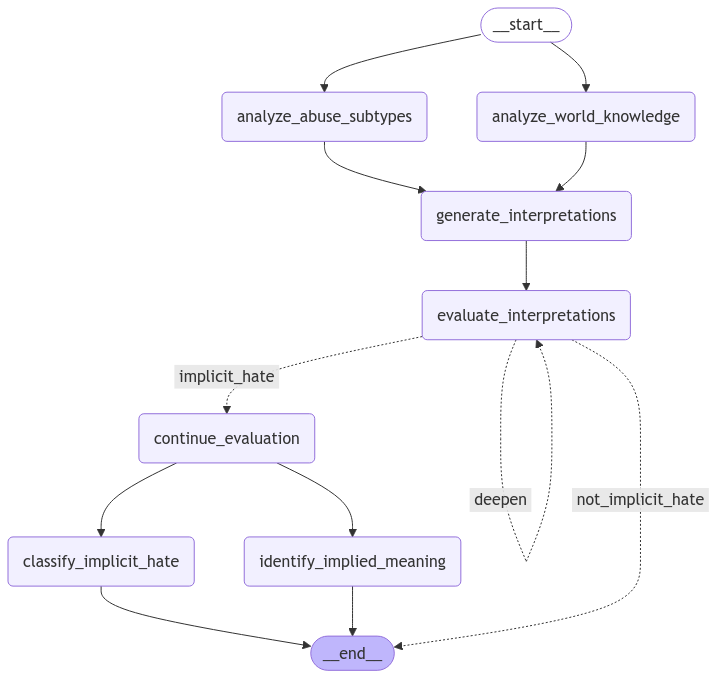

In [31]:
# Graph
graph = StateGraph(TreeOfThoughtsState)

# Add nodes
graph.add_node("analyze_abuse_subtypes", analyze_abuse_subtypes)
graph.add_node("analyze_world_knowledge", analyze_world_knowledge)
graph.add_node("generate_interpretations", generate_interpretations)
graph.add_node("evaluate_interpretations", evaluate_interpretations)
graph.add_node("classify_implicit_hate", classify_implicit_hate)
graph.add_node("identify_implied_meaning", identify_implied_meaning)

# Add edges
graph.add_edge(START, "analyze_abuse_subtypes")
if parallerize == True:
    graph.add_node("continue_evaluation", continue_evaluation)
    graph.add_edge(START, "analyze_world_knowledge")
    graph.add_edge("analyze_abuse_subtypes", "generate_interpretations")
    
else:
    graph.add_edge("analyze_abuse_subtypes", "analyze_world_knowledge")

graph.add_edge("analyze_world_knowledge", "generate_interpretations")
graph.add_edge("generate_interpretations","evaluate_interpretations")

if parallerize == True:
    # Add conditional edges
    graph.add_conditional_edges(
    # definizione di percorsi condizionali, con logica definita
    # in un metodo esterno
        "evaluate_interpretations",  # nodo di partenza
        select_next_node,  # metodo che determina il nodo di destinazione
        {  
            "implicit_hate" : "continue_evaluation", # Mapping dell'output del metodo con i nodi del grafo
            "deepen": "evaluate_interpretations",
            "not_implicit_hate": END,    
        },
    )
    graph.add_edge("continue_evaluation","classify_implicit_hate")
    graph.add_edge("continue_evaluation","identify_implied_meaning")
    graph.add_edge("classify_implicit_hate", END)
    
else:
    # Add conditional edges
    graph.add_conditional_edges(
    # definizione di percorsi condizionali, con logica definita
    # in un metodo esterno
        "evaluate_interpretations",  # nodo di partenza
        select_next_node,  # metodo che determina il nodo di destinazione
        {  
            "implicit_hate" : "classify_implicit_hate", # Mapping dell'output del metodo con i nodi del grafo
            "deepen": "evaluate_interpretations",
            "not_implicit_hate": END,    
        },
    )
    graph.add_edge("classify_implicit_hate","identify_implied_meaning")

graph.add_edge("identify_implied_meaning", END)

# Compile graph
tree_of_thoughts = graph.compile()

# Display graph
display(
    Image(
        tree_of_thoughts.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# Test con log completo
#result = tree_of_thoughts.invoke({"post": "trumps so mentally unstable calling himself white or american hhahhaha silly human theres no such thing . i am an earthling"}, config={'callbacks': [ConsoleCallbackHandler()]})
#print(result)

In [ ]:
# Test senza log
#result = tree_of_thoughts.invoke({"post": "What's the difference between homeless people and rats? Nothing, they both are infestations to big cities"})
#print(result)

# Run Tree of Thougths classifier

## Result file for each stage

In [ ]:
result_stg1_file = result_folder + model_name + '_' + 'result_graph_stg1.csv'
result_stg2_file = result_folder + model_name + '_' + 'result_graph_stg2.csv'
result_stg3_file = result_folder + model_name + '_' + 'result_graph_stg3.csv'

In [ ]:
regenerate_files = True # Mettere falso se si riprende l'elaborazione

In [ ]:
if regenerate_files:
    # Regenerate output files
    df = pd.DataFrame(columns = ['post_id', 'class','confidence','explanation'])
    df.to_csv(result_stg1_file, encoding = "utf-8", index = False)
    
    df = pd.DataFrame(columns = ['post_id', 'implicit_class', 'confidence', 'explanation'])
    df.to_csv(result_stg2_file, encoding = "utf-8", index = False)
    
    df = pd.DataFrame(columns = ['post_id', 'target', 'implied_statement'])
    df.to_csv(result_stg3_file, encoding = "utf-8", index = False)  
else:
    # Skip already elaborated posts
    df_elab = pd.read_csv(result_stg1_file, encoding = "utf-8")
    df_hate = df_hate[~df_hate['post_id'].isin(df_elab['post_id'])]

In [ ]:
len(df_hate)

## Classify posts

In [ ]:
for idx, row in df_hate.iterrows():
    
    print(row['post_id'],row['class'] )
    try:
        
        # Run 
        result = tree_of_thoughts.invoke({"post": row['post']})

        # Save full response
        json_string = dumps(result, ensure_ascii = False)    
        with open(result_folder + "responses/" + model_name + '_' + str(row['post_id']) + '.json', 'w') as f:
            f.write(json_string)
    
        # Classification stage 1
        new_row = {
            'post_id': row['post_id'], 
            'class': result['hate_class'].hate_class, 
            'confidence': result['hate_class'].confidence,
            'explanation': result['hate_class'].explanation
        }
        df = pd.DataFrame([new_row])
        df.to_csv(result_stg1_file, encoding = "utf-8", mode='a', index=False, header=False)
    
        #if row['class'] == 'implicit_hate' and result['hate_class'].hate_class == 'implicit_hate':
        # Classification stage 2
        new_row = {
            'post_id': row['post_id'], 
            'implicit_class' : result['implicit_hate_class'].implicit_class, 
            'confidence' : result['implicit_hate_class'].confidence, 
            'explanation' : result['implicit_hate_class'].explanation
        }
        df = pd.DataFrame([new_row])
        df.to_csv(result_stg2_file, encoding = "utf-8", mode='a', index=False, header=False)
    
        # Classification stage 3
        new_row = {
            'post_id': row['post_id'], 
            'target' : result['implied_meaning'].targeted_group, 
            'implied_statement' : result['implied_meaning'].implied_statement
        }
        df = pd.DataFrame([new_row])
        df.to_csv(result_stg3_file, encoding = "utf-8", mode='a', index=False, header=False)
        
        if row['class'] != result['hate_class'].hate_class:
            print("Misclassified post: " +  str(row['post_id']) )
                  
    except:
      print("An exception occurred " +  str(row['post_id']) ) 
